# Whole image quality control metric evaluation - Blur

In this notebook, we will use the outputted QC metrics per image (every z-slice per channel) to start working on developing thresholds using z-score to flag images during CellProfiler processing.
We are loading in the results from the preliminary data (across three patients) to attempt to develop generalizable thresholds.
This data is 3D, so we are decide if it make sense to remove a whole organoid based on if one z-slice fails.

## Blurry image detection

For detecting poor quality images based on blur, we use the feature `PowerLogLogSlope`, where more negative values indicate blurry images.
We first create distribution plots per plates and per channel to evaluate if the distributions across channels are different.
We will use this to determine if we process the data with all channels combined or separately.

We will use a method called `coSMicQC`, which takes a feature of interest and detect outliers based on z-scoring and how far from the mean that outliers will be.

## Import libraries

In [1]:
import pathlib
import pandas as pd
import cosmicqc
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Set paths and variables

In [2]:
# Set the threshold for identifying outliers with z-scoring for all metrics (# of standard deviations away from mean)
threshold_z = 2

# Directory for figures to be outputted
figure_dir = pathlib.Path("../qc_figures")
figure_dir.mkdir(exist_ok=True)

# Directory containing the QC results
qc_results_dir = pathlib.Path("../qc_results")

# Find all Image.csv files for all plates using glob
image_csv_paths = qc_results_dir.glob("*/Image.csv")

# Path to the template pipeline file to update with proper thresholds for flagging
pipeline_path = pathlib.Path("../pipeline/template_flag_pipeline.cppipe")

## Load in QC results per plate and combine

In [3]:
# Define prefixes for columns to select
prefixes = (
    "Metadata",
    "FileName",
    "PathName",
    "ImageQuality_PowerLogLogSlope",
)

# Load and concatenate the data for all plates
qc_dfs = []
for path in image_csv_paths:
    # Load only the required columns by filtering columns with specified prefixes
    plate_df = pd.read_csv(path, usecols=lambda col: col.startswith(prefixes))
    
    # Check for NaNs in the Metadata_Plate, Metadata_Well, and Metadata_Site columns
    if plate_df[["Metadata_Plate", "Metadata_Well", "Metadata_Site"]].isna().any().any():
        print(f"NaNs detected in {path} in Metadata_Plate, Metadata_Well, or Metadata_Site columns")
    
    # Fill NaNs for specific conditions
    if "NF0018_qc_results" in str(path):
        plate_df["Metadata_Plate"] = plate_df["Metadata_Plate"].fillna("NF0018")
        plate_df["Metadata_Well"] = plate_df["Metadata_Well"].fillna("E5")
        plate_df["Metadata_Site"] = plate_df["Metadata_Site"].fillna(3)
    
    qc_dfs.append(plate_df)

NaNs detected in ../qc_results/NF0018_qc_results/Image.csv in Metadata_Plate, Metadata_Well, or Metadata_Site columns


In [4]:
# Concatenate all plate data into a single dataframe
concat_qc_df = pd.concat(qc_dfs, ignore_index=True)

# Add a new column Metadata_zslice_total which gets the number of rows per Metadata_Plate, Metadata_Well, and Metadata_Site unique combos
concat_qc_df["Metadata_zslice_total"] = concat_qc_df.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"]
)["Metadata_Site"].transform("count")

print(concat_qc_df.shape)
concat_qc_df.head(2)

(9938, 24)


,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,ImageQuality_PowerLogLogSlope_AGP,ImageQuality_PowerLogLogSlope_Brightfield,ImageQuality_PowerLogLogSlope_DNA,ImageQuality_PowerLogLogSlope_ER,ImageQuality_PowerLogLogSlope_Mito,...,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
0,C10-1 (60X)_555_ZS000_FOV-1.tif,C10-1 (60X)_TRANS_ZS000_FOV-1.tif,C10-1 (60X)_405_ZS000_FOV-1.tif,C10-1 (60X)_488_ZS000_FOV-1.tif,C10-1 (60X)_640_ZS000_FOV-1.tif,-0.490456,-0.452916,-0.719789,-1.124944,-0.474988,...,0,1.0,C10,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,23
1,C10-1 (60X)_555_ZS001_FOV-1.tif,C10-1 (60X)_TRANS_ZS001_FOV-1.tif,C10-1 (60X)_405_ZS001_FOV-1.tif,C10-1 (60X)_488_ZS001_FOV-1.tif,C10-1 (60X)_640_ZS001_FOV-1.tif,-0.629910,-0.437189,-0.895604,-1.252999,-0.687768,...,0,1.0,C10,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,23


## Generate blur density distribution plot

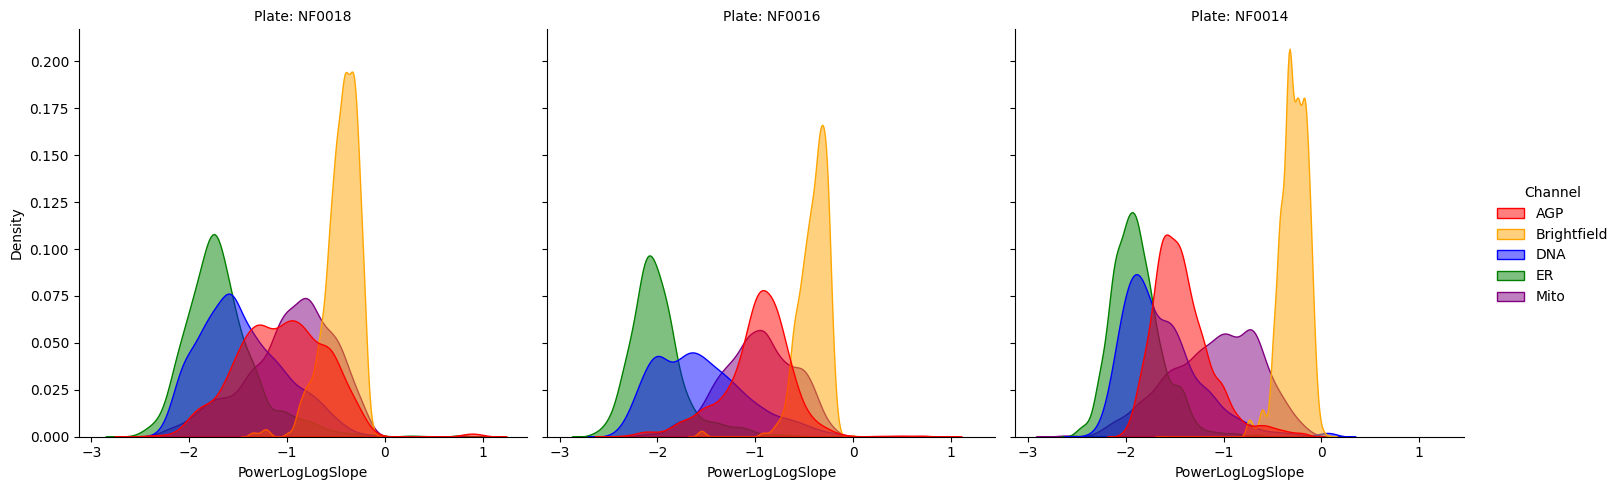

In [5]:
# Step 1: Select only the columns containing "PowerLogLogSlope" and keep Metadata_Plate
relevant_columns = [col for col in concat_qc_df.columns if "PowerLogLogSlope" in col]
relevant_columns.insert(0, "Metadata_Plate")

# Filter the dataframe
filtered_df = concat_qc_df[relevant_columns]

# Step 2: Reshape the dataframe into a long format
long_df = filtered_df.melt(
    id_vars=["Metadata_Plate"], var_name="Channel", value_name="PowerLogLogSlope"
)

# Step 3: Clean up the channel names
long_df["Channel"] = long_df["Channel"].str.replace(
    "ImageQuality_PowerLogLogSlope_", ""
)

# Drop rows with missing or non-numeric values
long_df = long_df.dropna(subset=["PowerLogLogSlope"])

# Define the custom color palette
custom_palette = {
    "DNA": "blue",
    "ER": "green",
    "AGP": "red",
    "Mito": "purple",
    "Brightfield": "orange",
}

# Step 4: Create the facet grid
g = sns.displot(
    data=long_df,
    x="PowerLogLogSlope",
    hue="Channel",
    palette=custom_palette,  # Use the custom palette
    col="Metadata_Plate",
    kind="kde",
    fill=True,
    alpha=0.5,
    col_wrap=3,  # Adjust for 3 columns per row
)

# Customize the plot
g.set_titles("Plate: {col_name}")
g.set_axis_labels("PowerLogLogSlope", "Density")
g.tight_layout()

# Show the plot
plt.show()

Given the plot, we can conclude that the distributions across channels are very different.
We will process each channel independently and determine thresholds per channel.
The distributions across plate look similar, so we will not be determining per plate.

## Detect blur in DNA channel

In [6]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_DNA_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_DNA": -2,
    },
)

pd.DataFrame(blur_DNA_outliers)

Number of outliers: 3 (0.03%)
Outliers Range:
ImageQuality_PowerLogLogSlope_DNA Min: -2.43397168794044
ImageQuality_PowerLogLogSlope_DNA Max: -2.423613126426449


,ImageQuality_PowerLogLogSlope_DNA,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
3749,-2.433972,G9-1 (60X)_555_ZS008_FOV-1.tif,G9-1 (60X)_TRANS_ZS008_FOV-1.tif,G9-1 (60X)_405_ZS008_FOV-1.tif,G9-1 (60X)_488_ZS008_FOV-1.tif,G9-1 (60X)_640_ZS008_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,G9,ZS008,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,15
4410,-2.423613,D2-2 (60X)_555_ZS010_FOV-1.tif,D2-2 (60X)_TRANS_ZS010_FOV-1.tif,D2-2 (60X)_405_ZS010_FOV-1.tif,D2-2 (60X)_488_ZS010_FOV-1.tif,D2-2 (60X)_640_ZS010_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,D2,ZS010,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,19
4411,-2.428283,D2-2 (60X)_555_ZS011_FOV-1.tif,D2-2 (60X)_TRANS_ZS011_FOV-1.tif,D2-2 (60X)_405_ZS011_FOV-1.tif,D2-2 (60X)_488_ZS011_FOV-1.tif,D2-2 (60X)_640_ZS011_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,D2,ZS011,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,19


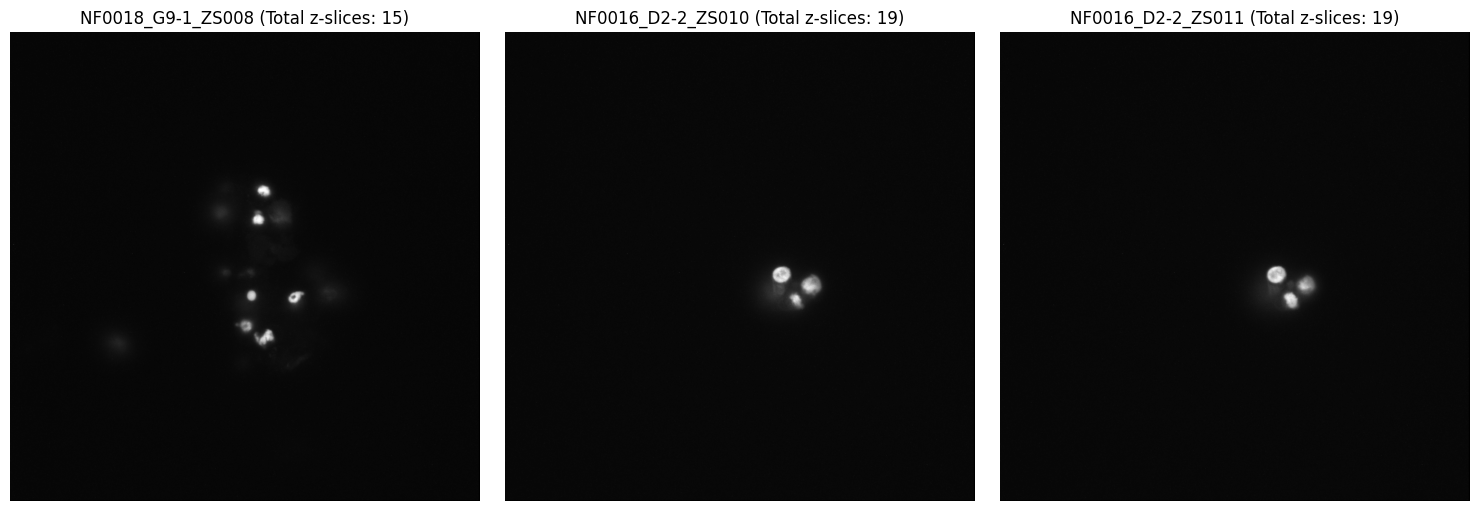

In [7]:
# Combine PathName and FileName columns to construct full paths for DNA
blur_DNA_outliers["Full_Path_DNA"] = (
    blur_DNA_outliers["PathName_DNA"] + "/" + blur_DNA_outliers["FileName_DNA"]
)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the first 3 rows of the blur_DNA_outliers dataframe and display each image
for idx, row in enumerate(blur_DNA_outliers.itertuples(), start=1):
    if idx > 3:  # Only display the first 3 images
        break
    image_path = row.Full_Path_DNA
    # Format the metadata title
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Detect blur in Mito channel

In [8]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_Mito_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_Mito": -3,
    },
)

pd.DataFrame(blur_Mito_outliers)

blur_Mito_outliers = blur_Mito_outliers.sort_values(
    by="ImageQuality_PowerLogLogSlope_Mito", ascending=True
)

blur_Mito_outliers.head()

Number of outliers: 10 (0.10%)
Outliers Range:
ImageQuality_PowerLogLogSlope_Mito Min: -2.6491286894863624
ImageQuality_PowerLogLogSlope_Mito Max: -2.348196327663946


,ImageQuality_PowerLogLogSlope_Mito,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
7519,-2.649129,D5-1_555_ZS008_FOV-1.tif,D5-1_TRANS_ZS008_FOV-1.tif,D5-1_405_ZS008_FOV-1.tif,D5-1_488_ZS008_FOV-1.tif,D5-1_640_ZS008_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,D5,ZS008,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,11
7520,-2.645535,D5-1_555_ZS009_FOV-1.tif,D5-1_TRANS_ZS009_FOV-1.tif,D5-1_405_ZS009_FOV-1.tif,D5-1_488_ZS009_FOV-1.tif,D5-1_640_ZS009_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,D5,ZS009,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,11
7518,-2.644559,D5-1_555_ZS007_FOV-1.tif,D5-1_TRANS_ZS007_FOV-1.tif,D5-1_405_ZS007_FOV-1.tif,D5-1_488_ZS007_FOV-1.tif,D5-1_640_ZS007_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,D5,ZS007,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,11
7517,-2.631257,D5-1_555_ZS006_FOV-1.tif,D5-1_TRANS_ZS006_FOV-1.tif,D5-1_405_ZS006_FOV-1.tif,D5-1_488_ZS006_FOV-1.tif,D5-1_640_ZS006_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,D5,ZS006,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,11
7516,-2.593937,D5-1_555_ZS005_FOV-1.tif,D5-1_TRANS_ZS005_FOV-1.tif,D5-1_405_ZS005_FOV-1.tif,D5-1_488_ZS005_FOV-1.tif,D5-1_640_ZS005_FOV-1.tif,NaN,NaN,0,NF0014,0,1.0,D5,ZS005,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,11


3


/tmp/ipykernel_60111/2271308443.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


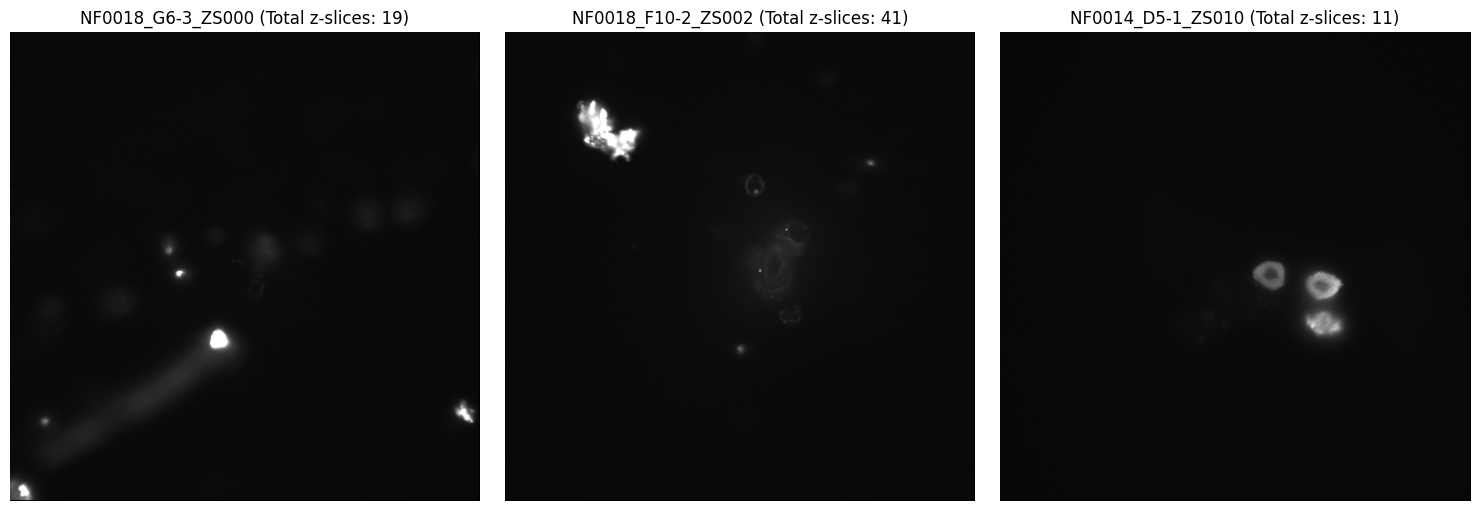

In [9]:
# Combine PathName and FileName columns to construct full paths for Mito
blur_Mito_outliers["Full_Path_Mito"] = (
    blur_Mito_outliers["PathName_Mito"] + "/" + blur_Mito_outliers["FileName_Mito"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = blur_Mito_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"]
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(selected_images.itertuples(), start=1):
    image_path = row.Full_Path_Mito
    # Format the metadata title
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)  # Set the formatted metadata as the title
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Detect blur in ER channel

In [10]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_er_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_ER": -2,
    },
)

pd.DataFrame(blur_er_outliers).head()

Number of outliers: 22 (0.22%)
Outliers Range:
ImageQuality_PowerLogLogSlope_ER Min: -2.6877688895713843
ImageQuality_PowerLogLogSlope_ER Max: -2.5449296679132503


,ImageQuality_PowerLogLogSlope_ER,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
3705,-2.632592,G8-4 (60X)_555_ZS000_FOV-1.tif,G8-4 (60X)_TRANS_ZS000_FOV-1.tif,G8-4 (60X)_405_ZS000_FOV-1.tif,G8-4 (60X)_488_ZS000_FOV-1.tif,G8-4 (60X)_640_ZS000_FOV-1.tif,NaN,NaN,0,NF0018,0,4.0,G8,ZS000,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,21
3706,-2.570605,G8-4 (60X)_555_ZS001_FOV-1.tif,G8-4 (60X)_TRANS_ZS001_FOV-1.tif,G8-4 (60X)_405_ZS001_FOV-1.tif,G8-4 (60X)_488_ZS001_FOV-1.tif,G8-4 (60X)_640_ZS001_FOV-1.tif,NaN,NaN,0,NF0018,0,4.0,G8,ZS001,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,21
4798,-2.566073,D9-2 (60X)_555_ZS011_FOV-1.tif,D9-2 (60X)_TRANS_ZS011_FOV-1.tif,D9-2 (60X)_405_ZS011_FOV-1.tif,D9-2 (60X)_488_ZS011_FOV-1.tif,D9-2 (60X)_640_ZS011_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,D9,ZS011,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
4799,-2.629261,D9-2 (60X)_555_ZS012_FOV-1.tif,D9-2 (60X)_TRANS_ZS012_FOV-1.tif,D9-2 (60X)_405_ZS012_FOV-1.tif,D9-2 (60X)_488_ZS012_FOV-1.tif,D9-2 (60X)_640_ZS012_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,D9,ZS012,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
4800,-2.628217,D9-2 (60X)_555_ZS013_FOV-1.tif,D9-2 (60X)_TRANS_ZS013_FOV-1.tif,D9-2 (60X)_405_ZS013_FOV-1.tif,D9-2 (60X)_488_ZS013_FOV-1.tif,D9-2 (60X)_640_ZS013_FOV-1.tif,NaN,NaN,0,NF0016,0,2.0,D9,ZS013,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17


7


/tmp/ipykernel_60111/4104768839.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


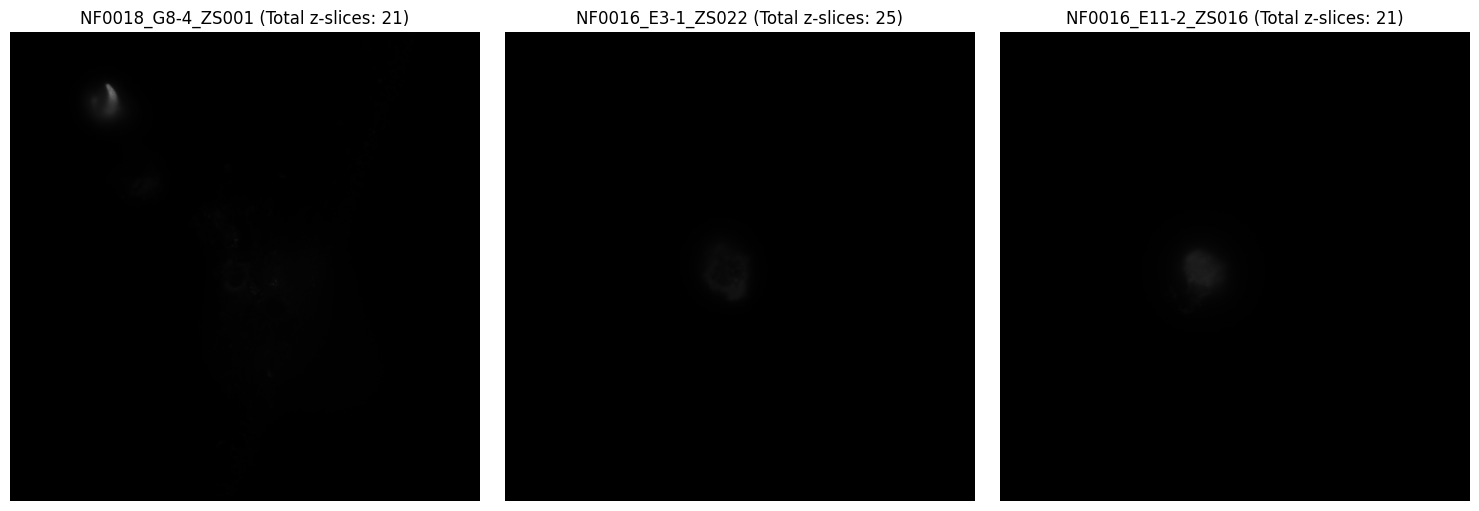

In [11]:
# Combine PathName and FileName columns to construct full paths
blur_er_outliers["Full_Path_ER"] = (
    blur_er_outliers["PathName_ER"] + "/" + blur_er_outliers["FileName_ER"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = blur_er_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_ER
    # Format the metadata title
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Detect blur in AGP channel

In [12]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_agp_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_AGP": -2.25,
    },
)

pd.DataFrame(blur_agp_outliers).head()

Number of outliers: 36 (0.36%)
Outliers Range:
ImageQuality_PowerLogLogSlope_AGP Min: -2.5032345709272894
ImageQuality_PowerLogLogSlope_AGP Max: -2.1323267196608637


,ImageQuality_PowerLogLogSlope_AGP,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
491,-2.132716,C8-1 (60X)_555_ZS013_FOV-1.tif,C8-1 (60X)_TRANS_ZS013_FOV-1.tif,C8-1 (60X)_405_ZS013_FOV-1.tif,C8-1 (60X)_488_ZS013_FOV-1.tif,C8-1 (60X)_640_ZS013_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,C8,ZS013,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
492,-2.179792,C8-1 (60X)_555_ZS014_FOV-1.tif,C8-1 (60X)_TRANS_ZS014_FOV-1.tif,C8-1 (60X)_405_ZS014_FOV-1.tif,C8-1 (60X)_488_ZS014_FOV-1.tif,C8-1 (60X)_640_ZS014_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,C8,ZS014,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
493,-2.218744,C8-1 (60X)_555_ZS015_FOV-1.tif,C8-1 (60X)_TRANS_ZS015_FOV-1.tif,C8-1 (60X)_405_ZS015_FOV-1.tif,C8-1 (60X)_488_ZS015_FOV-1.tif,C8-1 (60X)_640_ZS015_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,C8,ZS015,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
494,-2.240774,C8-1 (60X)_555_ZS016_FOV-1.tif,C8-1 (60X)_TRANS_ZS016_FOV-1.tif,C8-1 (60X)_405_ZS016_FOV-1.tif,C8-1 (60X)_488_ZS016_FOV-1.tif,C8-1 (60X)_640_ZS016_FOV-1.tif,NaN,NaN,0,NF0018,0,1.0,C8,ZS016,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,17
884,-2.151379,D3-2 (60X)_555_ZS007_FOV-1.tif,D3-2 (60X)_TRANS_ZS007_FOV-1.tif,D3-2 (60X)_405_ZS007_FOV-1.tif,D3-2 (60X)_488_ZS007_FOV-1.tif,D3-2 (60X)_640_ZS007_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D3,ZS007,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,37


7


/tmp/ipykernel_60111/1038515282.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))


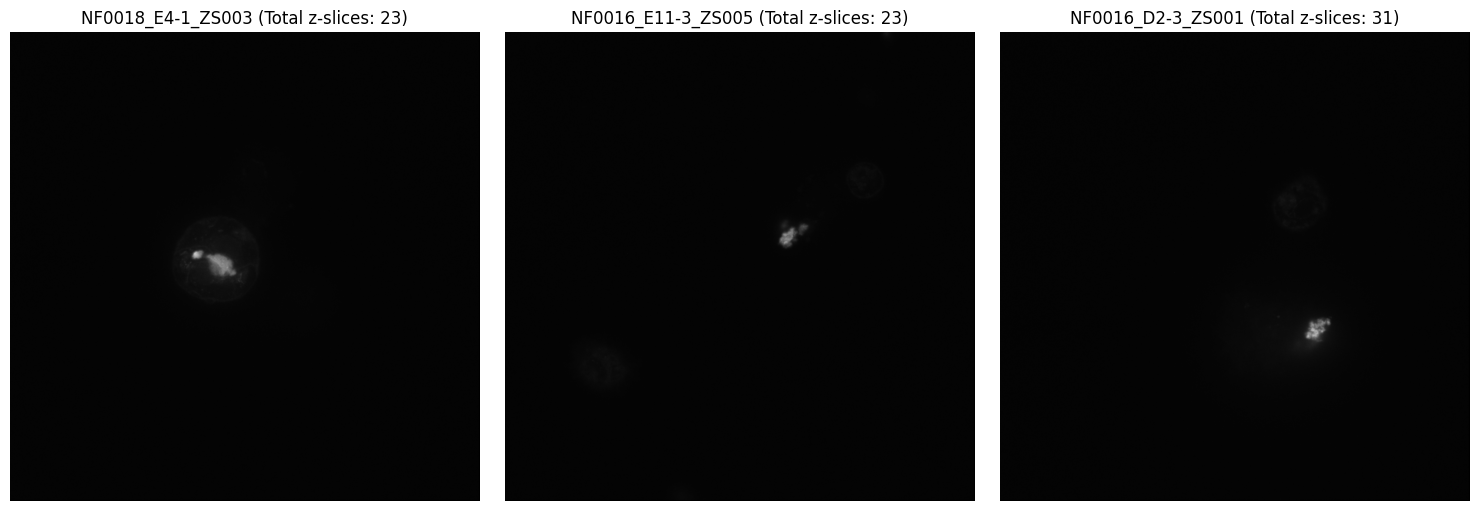

In [13]:
# Combine PathName and FileName columns to construct full paths
blur_agp_outliers["Full_Path_AGP"] = (
    blur_agp_outliers["PathName_AGP"] + "/" + blur_agp_outliers["FileName_AGP"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = blur_agp_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=0))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=0)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_AGP
    # Format the metadata title
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Detect blur in Brightfield channel

In [14]:
# Identify metadata columns (columns that do not start with 'ImageQuality')
metadata_columns = [
    col for col in concat_qc_df.columns if not col.startswith("ImageQuality")
]

# Find large nuclei outliers for the current plate
blur_brightfield_outliers = cosmicqc.find_outliers(
    df=concat_qc_df,
    metadata_columns=metadata_columns,
    feature_thresholds={
        "ImageQuality_PowerLogLogSlope_Brightfield": -3,
    },
)

pd.DataFrame(blur_brightfield_outliers).head()

Number of outliers: 76 (0.76%)
Outliers Range:
ImageQuality_PowerLogLogSlope_Brightfield Min: -1.622362126637527
ImageQuality_PowerLogLogSlope_Brightfield Max: -0.9019161522128636


,ImageQuality_PowerLogLogSlope_Brightfield,FileName_AGP,FileName_Brightfield,FileName_DNA,FileName_ER,FileName_Mito,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Zslice,PathName_AGP,PathName_Brightfield,PathName_DNA,PathName_ER,PathName_Mito,Metadata_zslice_total
999,-0.901916,D4-2 (60X)_555_ZS043_FOV-1.tif,D4-2 (60X)_TRANS_ZS043_FOV-1.tif,D4-2 (60X)_405_ZS043_FOV-1.tif,D4-2 (60X)_488_ZS043_FOV-1.tif,D4-2 (60X)_640_ZS043_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D4,ZS043,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,57
1000,-0.906202,D4-2 (60X)_555_ZS044_FOV-1.tif,D4-2 (60X)_TRANS_ZS044_FOV-1.tif,D4-2 (60X)_405_ZS044_FOV-1.tif,D4-2 (60X)_488_ZS044_FOV-1.tif,D4-2 (60X)_640_ZS044_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D4,ZS044,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,57
1001,-0.916433,D4-2 (60X)_555_ZS045_FOV-1.tif,D4-2 (60X)_TRANS_ZS045_FOV-1.tif,D4-2 (60X)_405_ZS045_FOV-1.tif,D4-2 (60X)_488_ZS045_FOV-1.tif,D4-2 (60X)_640_ZS045_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D4,ZS045,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,57
1002,-0.922332,D4-2 (60X)_555_ZS046_FOV-1.tif,D4-2 (60X)_TRANS_ZS046_FOV-1.tif,D4-2 (60X)_405_ZS046_FOV-1.tif,D4-2 (60X)_488_ZS046_FOV-1.tif,D4-2 (60X)_640_ZS046_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D4,ZS046,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,57
1003,-0.933599,D4-2 (60X)_555_ZS047_FOV-1.tif,D4-2 (60X)_TRANS_ZS047_FOV-1.tif,D4-2 (60X)_405_ZS047_FOV-1.tif,D4-2 (60X)_488_ZS047_FOV-1.tif,D4-2 (60X)_640_ZS047_FOV-1.tif,NaN,NaN,0,NF0018,0,2.0,D4,ZS047,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,/media/18tbdrive/1.Github_Repositories/GFF_3D_...,57


7


/tmp/ipykernel_60111/3680671671.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=1))


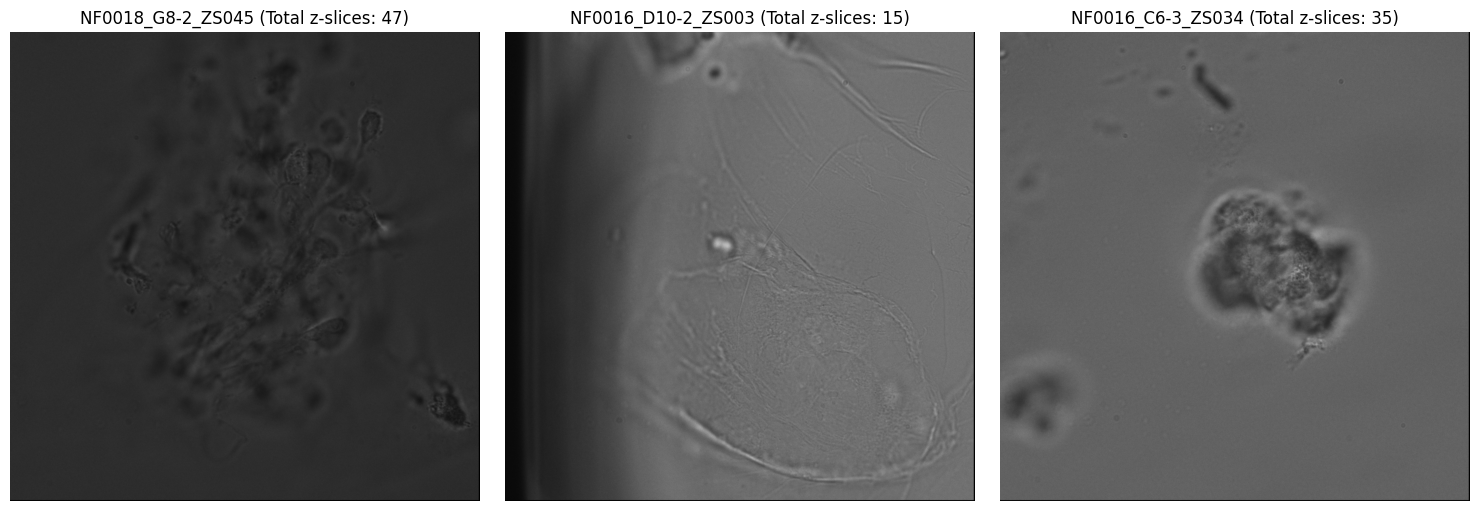

In [15]:
# Combine PathName and FileName columns to construct full paths
blur_brightfield_outliers["Full_Path_Brightfield"] = (
    blur_brightfield_outliers["PathName_Brightfield"]
    + "/"
    + blur_brightfield_outliers["FileName_Brightfield"]
)

# Group by Plate, Well, and Site to ensure uniqueness
unique_groups = blur_brightfield_outliers.groupby(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site"],
)
print(len(unique_groups))

# Randomly sample one row per group (select random state for best examples)
unique_samples = unique_groups.apply(lambda group: group.sample(n=1, random_state=1))

# Reset the index for convenience
unique_samples = unique_samples.reset_index(drop=True)

# Further randomly select 3 unique images (select random state for best examples)
if len(unique_samples) < 3:
    print("Not enough unique Plate-Well-Site combinations for the requested images.")
else:
    selected_images = unique_samples.sample(n=3, random_state=1)

# Create a figure to display images
plt.figure(figsize=(15, 5))

# Loop through the selected image paths and display each image
for idx, row in enumerate(
    selected_images.itertuples(), start=1
):  # Enumerate for subplot indexing
    image_path = row.Full_Path_Brightfield
    # Format the metadata title
    metadata_title = f"{row.Metadata_Plate}_{row.Metadata_Well}-{int(row.Metadata_Site)}_{row.Metadata_Zslice} (Total z-slices: {row.Metadata_zslice_total})"

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )  # Convert from BGR to RGB for proper display

    # Add the image to the plot
    plt.subplot(1, 3, idx)  # Use idx for subplot placement
    plt.imshow(image)
    plt.title(metadata_title)
    plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Create parquet file with each plate/well/site combos and boolean for pass/fail blur per channel

In [16]:
# Combine all blur outliers dataframes into a single dataframe
blur_outliers = pd.concat(
    [
        blur_DNA_outliers,
        blur_Mito_outliers,
        blur_agp_outliers,
        blur_brightfield_outliers,
        blur_er_outliers,
    ],
    keys=["DNA", "Mito", "AGP", "Brightfield", "ER"],
    names=["Channel"],
).reset_index(level="Channel")

# Create a new dataframe with only Metadata_Plate, Metadata_Well, Metadata_Site, and Metadata_Zslice columns to assign blur flags
blur_outliers_per_zslice = concat_qc_df[
    ["Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice"]
].drop_duplicates()

# Initialize columns for each channel with False
for channel in ["DNA", "Mito", "AGP", "Brightfield", "ER"]:
    blur_outliers_per_zslice[f"Blurry_{channel}"] = False

# Flag the combos for blur detection
for channel in ["DNA", "Mito", "AGP", "Brightfield", "ER"]:
    blur_combos = blur_outliers[blur_outliers["Channel"] == channel][
        ["Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice"]
    ].drop_duplicates()
    blur_outliers_per_zslice.loc[
        blur_outliers_per_zslice.set_index(
            ["Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice"]
        ).index.isin(
            blur_combos.set_index(
                ["Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice"]
            ).index
        ),
        f"Blurry_{channel}",
    ] = True

# Reset the index on the unique combos dataframe
blur_outliers_per_zslice = blur_outliers_per_zslice.reset_index(drop=True)

# Save the blur_outliers_per_zslice dataframe to a parquet file
blur_outliers_per_zslice.to_parquet(qc_results_dir / "all_plates_qc_results.parquet")

# Print the number of rows with at least one Blurry column set to True
num_blurry_rows = blur_outliers_per_zslice.loc[:, "Blurry_DNA":"Blurry_ER"].any(axis=1).sum()
print(
    f"Number of z-slices across all organoids detected as poor quality due to blur (in any channel): {num_blurry_rows}"
)

# Calculate and print the percentage of organoids detected as containing blur
percentage_blurry = (num_blurry_rows / len(blur_outliers_per_zslice)) * 100
print(
    f"Percentage of z-slices detected as poor quality due to blur: {percentage_blurry:.2f}%"
)

# Display the resulting dataframe
print(blur_outliers_per_zslice.shape)
blur_outliers_per_zslice.head()

Number of z-slices across all organoids detected as poor quality due to blur (in any channel): 147
Percentage of z-slices detected as poor quality due to blur: 1.48%
(9938, 9)


,Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Blurry_DNA,Blurry_Mito,Blurry_AGP,Blurry_Brightfield,Blurry_ER
0,NF0018,C10,1.0,ZS000,False,False,False,False,False
1,NF0018,C10,1.0,ZS001,False,False,False,False,False
2,NF0018,C10,1.0,ZS002,False,False,False,False,False
3,NF0018,C10,1.0,ZS003,False,False,False,False,False
4,NF0018,C10,1.0,ZS004,False,False,False,False,False
